<img src="../images/logos/xradar_logo.svg" width=250 alt="Xradar Logo"></img>

# Xradar Basics

---

## Overview
Within this notebook, we will highlight one of the newer packages in the Open Radar Science ecosystem, Xradar. Here is a brief overview of the motivation of this package:

```
At a developer meeting held in the course of the ERAD2022 conference in Locarno, Switzerland, future plans and cross-package collaboration of the Open Radar Science community were intensively discussed.

The consensus was that a close collaboration that benefits the entire community can only be maximized through joint projects. So the idea of a common software project whose only task is to read and write radar data was born. The data import should include as many available data formats as possible, but the data export should be limited to the recognized standards, such as ODIM_H5 and CfRadial.

As memory representation an xarray based data model was chosen, which is internally adapted to the forthcoming standard CfRadial2.1/FM301. FM301 is enforced by the Joint Expert Team on Operational Weather Radar (JET-OWR). Information on FM301 is available at WMO as WMO CF Extensions.

Any software package that uses xarray in any way will then be able to directly use the described data model and thus quickly and easily import and export radar data. Another advantage is the easy connection to already existing open source radar processing software.
```

We will highlight how to get started with xradar, including how to read in data, apply georeferencing, and visualize the datasets.

1. How to Read in Datasets + Basic Structure
1. Creating Plan Position Indicator (PPI) Plots Using Georeferencing
1. Slicing/Dicing Radar Datasets

## Prerequisites
Label the importance of each concept explicitly as **helpful/necessary**.

| Concepts | Importance | Notes |
| --- | --- | --- |
| [Introduction to Xarray](https://foundations.projectpythia.org/core/xarray/xarray-intro.html) | Required | Familiarity with Xarray Data Structure |
| [Intro to Cartopy](https://foundations.projectpythia.org/core/cartopy/cartopy.html) | Helpful | Basic Use of Cartopy Projections |
| [Understanding of NetCDF](https://foundations.projectpythia.org/core/data-formats/netcdf-cf.html) | Helpful | Familiarity with metadata structure |

- **Time to learn**: 15 minutes

---

## Imports

In [121]:
import cmweather
import numpy as np
import xarray as xr
import xradar as xd
import matplotlib.pyplot as plt
import cartopy

## How to Read in Datasets + Basic Structure

The first step is reading data. There are two main options here - including
- Xarray Backends
- Reading Using `xradar.io`

### Xarray Backends
The first option is to use `xarray.backends`, where we need to pass which reader to use. Xradar includes the following readers:
- `cfradial1`
- `odim`
- `gamic`
- `foruno`
- `rainbow`
- `iris` (sigmet)

These are passed into the typical `xr.open_dataset` call, with the reader fed into the `engine` argument.

For this exercise, we will use data from the University of Alabama Huntsville. They operate a C-band scanning precipitation radar, nicknamed ARMOR. The data from the radar are stored in `iris` files, a radar data format supported by xradar!

We need to use the `iris` reader here, specifying which sweep to access. Let's start with the lowest sweep, `sweep_0`.

In [46]:
file = "../../data/uah-armor/RAW_NA_000_125_20080411181219"

In [105]:
ds = xr.open_dataset(file,
                     group="sweep_0",
                     engine="iris")
ds

<xarray.Dataset>
Dimensions:            (azimuth: 360, range: 992)
Coordinates:
  * azimuth            (azimuth) float64 0.03296 1.033 1.994 ... 358.0 359.1
    elevation          (azimuth) float32 ...
    time               (azimuth) datetime64[ns] ...
  * range              (range) float32 1e+03 1.125e+03 ... 1.248e+05 1.249e+05
    longitude          float64 ...
    latitude           float64 ...
    altitude           float64 ...
Data variables: (12/13)
    DBTH               (azimuth, range) float32 ...
    DBZH               (azimuth, range) float32 ...
    VRADH              (azimuth, range) float32 ...
    WRADH              (azimuth, range) float32 ...
    ZDR                (azimuth, range) float32 ...
    KDP                (azimuth, range) float32 ...
    ...                 ...
    RHOHV              (azimuth, range) float32 ...
    sweep_mode         <U20 ...
    sweep_number       int64 ...
    prt_mode           <U7 ...
    follow_mode        <U7 ...
    sweep_fixed_angle  float64 ...

#### Add a Quick Plot of our Data
Now that we have our `xarray.Dataset`, we can investigate our data. Let's start with `DBZH`, or 
`Equivalent reflectivity factor H`

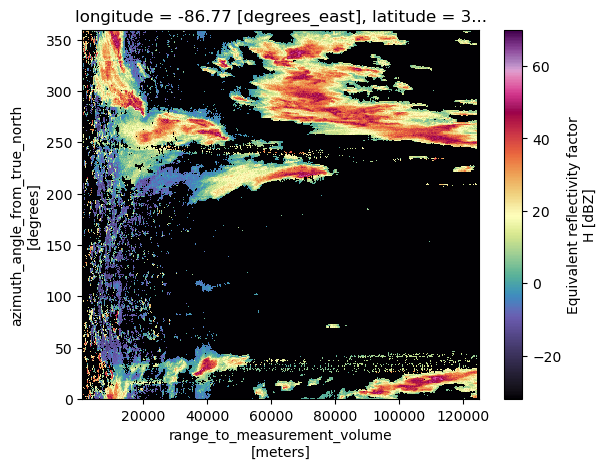

In [48]:
ds.DBZH.plot(cmap='ChaseSpectral',
             vmin=-32,
             vmax=70)

Notice how we have quite a few values of -32 - this is the missing data value for the radar. We can mask this using Xarray!

#### Mask Missing Values
We are looking for values that are not the missing value flag - so values not equal to -32 (`DBZH != -32`)

In [124]:
ds["DBZH"] = ds.DBZH.where(ds.DBZH != -32)

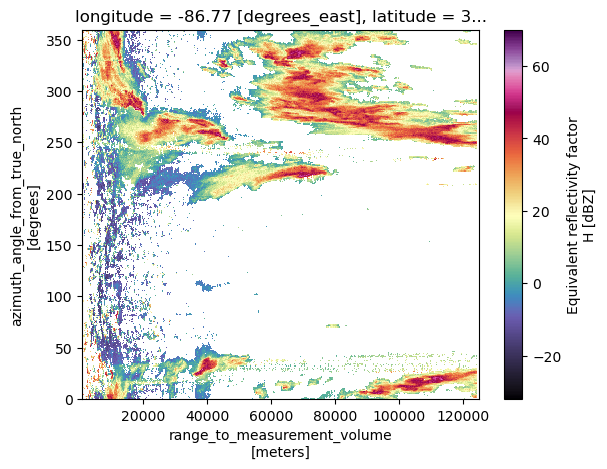

In [51]:
ds.DBZH.plot(cmap='ChaseSpectral',
             vmin=-32,
             vmax=70)

### Reading All of the Sweeps
Let's read in **all** of the sweeps from the volume. We need to use the `xradar.io.open_iris_datatree`

In [55]:
radar = xd.io.open_iris_datatree(file)
radar

DataTree('root', parent=None)
│   Dimensions:              ()
│   Data variables:
│       volume_number        int64 0
│       platform_type        <U5 'fixed'
│       instrument_type      <U5 'radar'
│       time_coverage_start  <U20 '2008-04-11T18:12:20Z'
│       time_coverage_end    <U20 '2008-04-11T18:16:17Z'
│       longitude            float64 -86.77
│       altitude             float64 200.0
│       latitude             float64 34.65
│   Attributes:
│       Conventions:      None
│       version:          None
│       title:            None
│       institution:      None
│       references:       None
│       source:           None
│       history:          None
│       comment:          im/exported using xradar
│       instrument_name:  None
├── DataTree('sweep_0')
│       Dimensions:            (azimuth: 360, range: 992)
│       Coordinates:
│         * azimuth            (azimuth) float64 0.03296 1.033 1.994 ... 358.0 359.1
│           elevation          (azimuth) float32 ...
│           time               (azimuth) datetime64[ns] 2008-04-11T18:12:23.213000 .....
│         * range              (range) float32 1e+03 1.125e+03 ... 1.248e+05 1.249e+05
│           longitude          float64 ...
│           latitude           float64 ...
│           altitude           float64 ...
│       Data variables: (12/13)
│           DBTH               (azimuth, range) float32 ...
│           DBZH               (azimuth, range) float32 ...
│           VRADH              (azimuth, range) float32 ...
│           WRADH              (azimuth, range) float32 ...
│           ZDR                (azimuth, range) float32 ...
│           KDP                (azimuth, range) float32 ...
│           ...                 ...
│           RHOHV              (azimuth, range) float32 ...
│           sweep_mode         <U20 ...
│           sweep_number       int64 ...
│           prt_mode           <U7 ...
│           follow_mode        <U7 ...
│           sweep_fixed_angle  float64 ...
├── DataTree('sweep_1')
│       Dimensions:            (azimuth: 360, range: 992)
│       Coordinates:
│         * azimuth            (azimuth) float64 0.07141 1.024 1.991 ... 358.0 359.0
│           elevation          (azimuth) float32 ...
│           time               (azimuth) datetime64[ns] 2008-04-11T18:12:41.064000 .....
│         * range              (range) float32 1e+03 1.125e+03 ... 1.248e+05 1.249e+05
│           longitude          float64 ...
│           latitude           float64 ...
│           altitude           float64 ...
│       Data variables: (12/13)
│           DBTH               (azimuth, range) float32 ...
│           DBZH               (azimuth, range) float32 ...
│           VRADH              (azimuth, range) float32 ...
│           WRADH              (azimuth, range) float32 ...
│           ZDR                (azimuth, range) float32 ...
│           KDP                (azimuth, range) float32 ...
│           ...                 ...
│           RHOHV              (azimuth, range) float32 ...
│           sweep_mode         <U20 ...
│           sweep_number       int64 ...
│           prt_mode           <U7 ...
│           follow_mode        <U7 ...
│           sweep_fixed_angle  float64 ...
├── DataTree('sweep_2')
│       Dimensions:            (azimuth: 360, range: 992)
│       Coordinates:
│         * azimuth            (azimuth) float64 0.06042 1.019 2.019 ... 358.1 359.0
│           elevation          (azimuth) float32 ...
│           time               (azimuth) datetime64[ns] 2008-04-11T18:13:16.929000 .....
│         * range              (range) float32 1e+03 1.125e+03 ... 1.248e+05 1.249e+05
│           longitude          float64 ...
│           latitude           float64 ...
│           altitude           float64 ...
│       Data variables: (12/13)
│           DBTH               (azimuth, range) float32 ...
│           DBZH               (azimuth, range) float32 ...
│           VRADH              (azimuth, range) float32 ...
│         

This object contains all of our sweeps! It is a hierachal data structure, which matches the `cfradial2` standard data structure.

In [54]:
list(radar.groups)

['/',
 '/sweep_0',
 '/sweep_1',
 '/sweep_2',
 '/sweep_3',
 '/sweep_4',
 '/sweep_5',
 '/sweep_6',
 '/sweep_7',
 '/sweep_8',
 '/sweep_9',
 '/sweep_10',
 '/sweep_11']

We can access one of the datasets in this tree by using the following syntax.

In [57]:
radar["sweep_0"].ds

<xarray.DatasetView>
Dimensions:            (azimuth: 360, range: 992)
Coordinates:
  * azimuth            (azimuth) float64 0.03296 1.033 1.994 ... 358.0 359.1
    elevation          (azimuth) float32 ...
    time               (azimuth) datetime64[ns] 2008-04-11T18:12:23.213000 .....
  * range              (range) float32 1e+03 1.125e+03 ... 1.248e+05 1.249e+05
    longitude          float64 ...
    latitude           float64 ...
    altitude           float64 ...
Data variables: (12/13)
    DBTH               (azimuth, range) float32 ...
    DBZH               (azimuth, range) float32 ...
    VRADH              (azimuth, range) float32 ...
    WRADH              (azimuth, range) float32 ...
    ZDR                (azimuth, range) float32 ...
    KDP                (azimuth, range) float32 ...
    ...                 ...
    RHOHV              (azimuth, range) float32 ...
    sweep_mode         <U20 ...
    sweep_number       int64 ...
    prt_mode           <U7 ...
    follow_mode        <U7 ...
    sweep_fixed_angle  float64 ...

#### Plot Data from the Tree
We can recreate a similar plot to before by pulling data from the tree, and calling `.plot()`

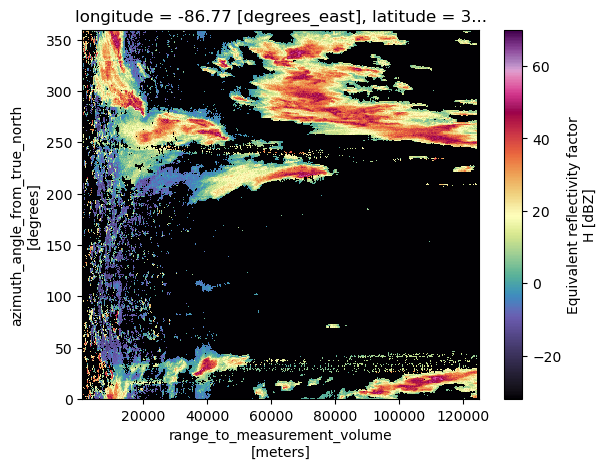

In [67]:
radar["sweep_0"]["DBZH"].plot(cmap='ChaseSpectral',
                              vmin=-32,
                              vmax=70)

## Creating Plan Position Indicator (PPI) Plots Using Georeferencing
While the plots we created in the previous section **can** be useful, typically scientists are more interested in PPI plots which give a better spatial view of the radar datasets.

### Georeference the Dataset
Xradar offers a `georeference` submodule, which utilizes the Azimuthal Equadistant Area projection to transform the data from distance around the radar to a projection.

In [69]:
ds.xradar.georeference?

Signature: ds.xradar.georeference(earth_radius=None, effective_radius_fraction=None) -> 'xr.Dataset'
Docstring:
Add georeference information to an xarray dataset
Parameters
----------
earth_radius: float
    Radius of the earth. Defaults to a latitude-dependent radius derived from
    WGS84 ellipsoid.
effective_radius_fraction: float
    Fraction of earth to use for the effective radius (default is 4/3).
Returns
-------
da = xarray.Dataset
    Dataset including x, y, and z as coordinates.
File:      ~/mambaforge/envs/ams-open-radar-2023-dev/lib/python3.10/site-packages/xradar/accessors.py
Type:      method

Let's use the default projection here. Notice how after calling this, we have `x`, `y`, and `z` added to the dataset. As well as the `spatial_ref` variable.

In [116]:
ds = ds.xradar.georeference()
ds

<xarray.Dataset>
Dimensions:            (azimuth: 360, range: 992)
Coordinates:
  * azimuth            (azimuth) float64 0.03296 1.033 1.994 ... 358.0 359.1
    elevation          (azimuth) float64 0.4614 0.4614 0.4614 ... 0.4614 0.4614
    time               (azimuth) datetime64[ns] ...
  * range              (range) float32 1e+03 1.125e+03 ... 1.248e+05 1.249e+05
    longitude          float64 -86.77
    latitude           float64 34.65
    altitude           float64 200.0
    spatial_ref        int64 0
    x                  (azimuth, range) float64 0.5752 0.6471 ... -2.011e+03
    y                  (azimuth, range) float64 999.9 1.125e+03 ... 1.248e+05
    z                  (azimuth, range) float64 208.1 209.1 ... 2.123e+03
Data variables: (12/13)
    DBTH               (azimuth, range) float32 ...
    DBZH               (azimuth, range) float64 -32.0 -32.0 ... -32.0 -32.0
    VRADH              (azimuth, range) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    WRADH              (azimuth, range) float32 ...
    ZDR                (azimuth, range) float32 ...
    KDP                (azimuth, range) float32 ...
    ...                 ...
    RHOHV              (azimuth, range) float32 ...
    sweep_mode         <U20 ...
    sweep_number       int64 ...
    prt_mode           <U7 ...
    follow_mode        <U7 ...
    sweep_fixed_angle  float64 ...

#### Use the New X/Y Fields to Plot a PPI

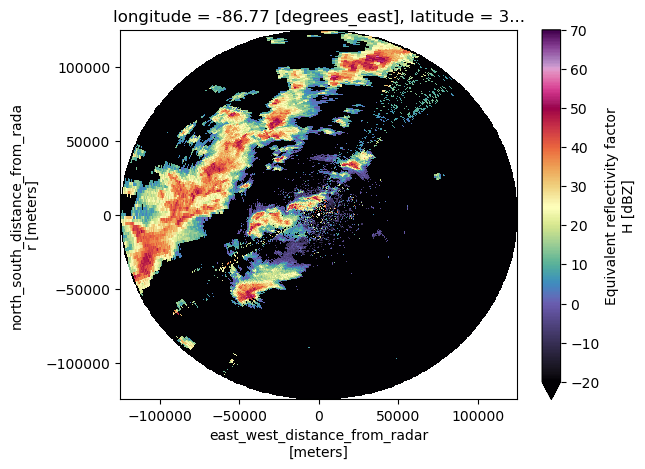

In [117]:
ds.DBZH.plot(x='x',
             y='y',
             cmap='ChaseSpectral',
             vmin=-20,
             vmax=70)

In [118]:
proj_crs = xd.georeference.get_crs(ds)
cart_crs = cartopy.crs.Projection(proj_crs)

/Users/mgrover/mambaforge/envs/ams-open-radar-2023-dev/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:1785: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  result = super().pcolormesh(*args, **kwargs)


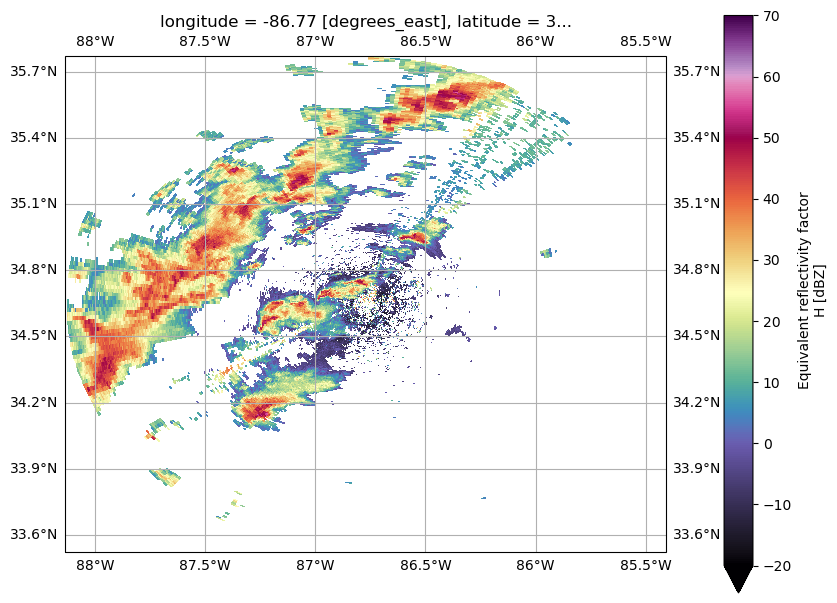

In [128]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection=cartopy.crs.PlateCarree())
ds["DBZH"].plot(
    x="x",
    y="y",
    cmap="ChaseSpectral",
    transform=cart_crs,
    cbar_kwargs=dict(pad=0.075, shrink=0.75),
    vmin=-20,
    vmax=70
)
ax.coastlines()
ax.gridlines(draw_labels=True)

## Slicing and Dicing Radar Data
Since we use the `xarray.Dataset` data structure here, we can make use of the subsetting interface!

### Subset along Azimuth
Let's start be selecting values along a given azimuth, or degrees around the radar. There are convective cells to the West (270 degrees), so we can start there. We need to specify `method='nearest'` in the case the value is not exactly what we are looking for.

In [139]:
subset_azimuth = ds.sel(azimuth=270,
                method='nearest')
subset_azimuth

<xarray.Dataset>
Dimensions:            (range: 992)
Coordinates:
    azimuth            float64 270.0
    elevation          float64 0.4614
    time               datetime64[ns] ...
  * range              (range) float32 1e+03 1.125e+03 ... 1.248e+05 1.249e+05
    longitude          float64 -86.77
    latitude           float64 34.65
    altitude           float64 200.0
    spatial_ref        int64 0
    x                  (range) float64 -999.9 -1.125e+03 ... -1.248e+05
    y                  (range) float64 0.04793 0.05393 0.05992 ... 5.979 5.985
    z                  (range) float64 208.1 209.1 210.2 ... 2.12e+03 2.123e+03
Data variables: (12/13)
    DBTH               (range) float32 ...
    DBZH               (range) float64 nan nan nan nan nan ... nan nan nan nan
    VRADH              (range) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    WRADH              (range) float32 ...
    ZDR                (range) float32 ...
    KDP                (range) float32 ...
    ...                 ...
    RHOHV              (range) float32 ...
    sweep_mode         <U20 ...
    sweep_number       int64 ...
    prt_mode           <U7 ...
    follow_mode        <U7 ...
    sweep_fixed_angle  float64 ...

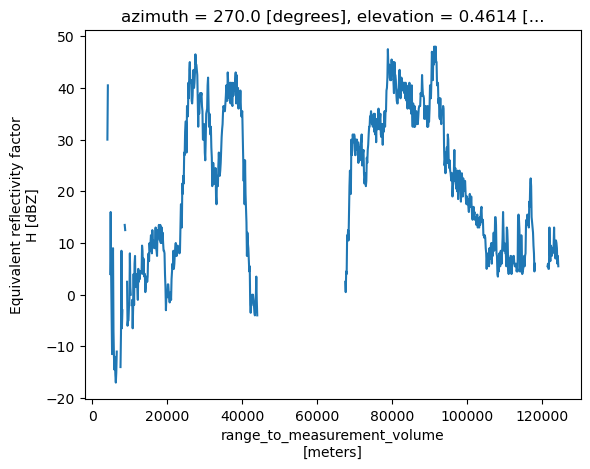

In [140]:
subset_azimuth.DBZH.plot()

### Subset Along the Range Dimension
We can follow a similar process for the range. Let's select from near the radar (0 meters from the radar) to 50 km (`50_000` meters) from the radar.

In [144]:
subset_range = ds.sel(range=slice(0, 50_000))
subset_range

<xarray.Dataset>
Dimensions:            (azimuth: 360, range: 393)
Coordinates:
  * azimuth            (azimuth) float64 0.03296 1.033 1.994 ... 358.0 359.1
    elevation          (azimuth) float64 0.4614 0.4614 0.4614 ... 0.4614 0.4614
    time               (azimuth) datetime64[ns] ...
  * range              (range) float32 1e+03 1.125e+03 ... 4.988e+04 5e+04
    longitude          float64 -86.77
    latitude           float64 34.65
    altitude           float64 200.0
    spatial_ref        int64 0
    x                  (azimuth, range) float64 0.5752 0.6471 ... -803.2 -805.2
    y                  (azimuth, range) float64 999.9 1.125e+03 ... 4.999e+04
    z                  (azimuth, range) float64 208.1 209.1 ... 748.0 749.8
Data variables: (12/13)
    DBTH               (azimuth, range) float32 ...
    DBZH               (azimuth, range) float64 nan nan nan nan ... nan nan nan
    VRADH              (azimuth, range) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    WRADH              (azimuth, range) float32 ...
    ZDR                (azimuth, range) float32 ...
    KDP                (azimuth, range) float32 ...
    ...                 ...
    RHOHV              (azimuth, range) float32 ...
    sweep_mode         <U20 ...
    sweep_number       int64 ...
    prt_mode           <U7 ...
    follow_mode        <U7 ...
    sweep_fixed_angle  float64 ...

#### Plot a PPI of the Range Subset

/Users/mgrover/mambaforge/envs/ams-open-radar-2023-dev/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:1785: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  result = super().pcolormesh(*args, **kwargs)


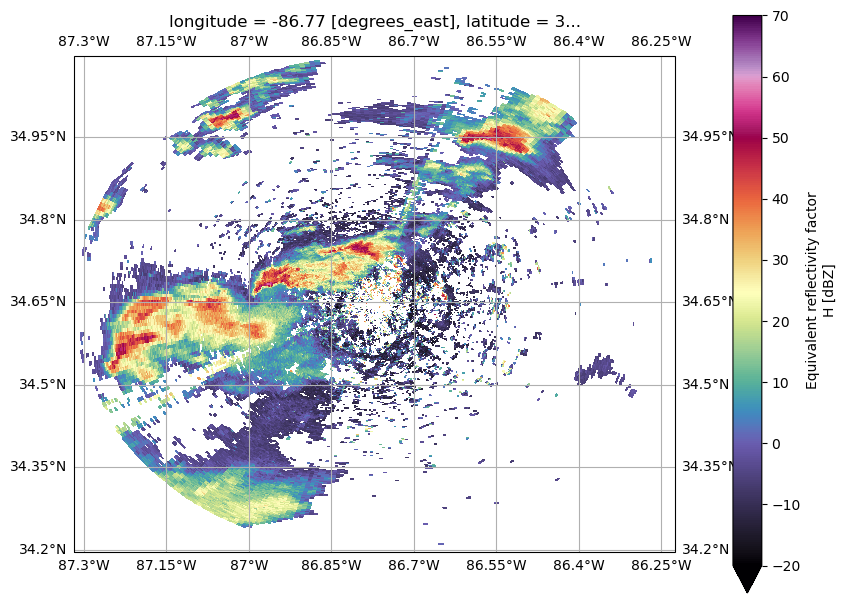

In [143]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection=cartopy.crs.PlateCarree())
subset_range["DBZH"].plot(
    x="x",
    y="y",
    cmap="ChaseSpectral",
    transform=cart_crs,
    cbar_kwargs=dict(pad=0.075, shrink=0.75),
    vmin=-20,
    vmax=70
)
ax.coastlines()
ax.gridlines(draw_labels=True)

In [ ]:
# some subsection code
new = "helpful information"

---

## Summary
Within this notebook, we took a look at the basics of the `xradar` package, and how it enables us to use the `xarray` ecosystem. The process from reading the data, applying filtering, subsetting, and visualizing the data was covered. We encourage users to explore the rest of the [xradar user guide](https://docs.openradarscience.org/projects/xradar/en/stable/usage.html) to continue learning how this tool is useful for their workflows.

### What's next?
We will take a look at other tools in the Open Radar Science stack, and the `wradlib` content will use these readers.

## Resources and references
- [xradar documentation](https://docs.openradarscience.org/projects/xradar/en/stable/index.html)
- [xarray documentation](https://docs.xarray.dev/en/stable/index.html)
